# Generate Figures for Word2Vec Year Models

The goal of this notebook is to observe how words are shifting through time since 2005. The year 2005 was selected as this is the only year the word 'CRISPR' appears in the Word2Vec models. This highlights the catch with Word2Vec models as they require words to appear at a given frequency within abstracts to be captured by the model.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import plotnine as p9
import tqdm
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

from biovectors_modules.plot_helper import (
    plot_token_timeline,
    plot_local_global_distances,
    plot_wordcloud_neighbors,
    plot_wordcloud_neighbors_gif,
)
from biovectors_modules.word2vec_analysis_helper import (
    generate_timeline,
    get_neighbors,
    project_token_timeline,
)

# Load Models to Observe Changes

In [2]:
aligned_models = pickle.load(open("output/aligned_word_vectors_2000_2020.pkl", "rb"))

In [3]:
year_comparison_dict = {
    "_".join(comparison_file.stem.split("_")[0:2]): (
        pd.read_csv(str(comparison_file), sep="\t")
    )
    for comparison_file in (list(Path("output/year_distances_2005_2020").rglob("*tsv")))
}
list(year_comparison_dict.keys())[0:3]

['2005_2006', '2005_2016', '2005_2019']

In [4]:
year_comparison_dict["2005_2006"].sort_values("global_dist")

,token,global_dist,local_dist,shift
11854,eine,0.023689,0.000146,0.023542
15576,het,0.024671,0.000038,0.024633
33452,werden,0.024700,0.000104,0.024596
33856,zur,0.029432,0.000104,0.029328
20402,might,0.030203,0.000189,0.030014
...,...,...,...,...
16755,immunosuppressants,1.369532,1.551107,-0.181575
7180,casp,1.370358,1.747629,-0.377271
6149,biocatalysis,1.394467,1.670357,-0.275890
4102,alf,1.407846,1.607599,-0.199753


## Train TSNE Model to Project Time Shifts into Two Dimensional Space

The goal here is to train a TSNE model that projects all words from 2005 to 2020 into a two dimensional space. Allows one to visually track how a word vector is shifting through time.

In [5]:
origin_df = aligned_models["2005"]
word_vectors = list(
    map(
        lambda x: x.query(f"token in {origin_df.token.tolist()}")
        .sort_values("token")
        .set_index("token")
        .values,
        list(aligned_models.values())[5:],
    )
)

In [6]:
word_models_stacked = np.vstack(word_vectors)
file_name = "output/2000_2020_umap_model"

In [7]:
if not Path(file_name).exists():
    Path(file_name).mkdir(parents=True)
    model = ParametricUMAP(verbose=True, metric="cosine", random_state=100)
    embedding = model.fit_transform(word_models_stacked)
    model.save(file_name)
else:
    model = load_ParametricUMAP(file_name)
model.verbose = False

Sun May 16 14:44:46 2021 Building and compiling search function
Pickle of ParametricUMAP model loaded from output/2000_2020_umap_model_replace/model.pkl
Keras encoder model loaded from output/2000_2020_umap_model_replace/encoder
Keras full model loaded from output/2000_2020_umap_model_replace/parametric_model


# Visualize Words Shifting through Time

This section is the same analysis mentioned in [03_word_decade_figure_generator_2000_2020.ipynb](03_word_decade_figure_generator_2000_2020.ipynb). The basic idea is to see how CRISPR shifts through time.

## CRISPR

In [8]:
token_timeline_df = generate_timeline(year_comparison_dict, "crispr")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
9497,crispr,0.322561,0.011248,0.311312,2005_2006
9497,crispr,0.633440,0.168471,0.464969,2005_2016
9497,crispr,0.675305,0.193707,0.481598,2005_2019
9497,crispr,0.573811,0.096072,0.477739,2005_2013
9497,crispr,0.514925,0.084995,0.429930,2005_2012


In [9]:
token_timeline_low_dim_df = project_token_timeline(
    "crispr", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,-0.379958,2.198134,2020,crispr,main
26,-0.474020,1.809389,2019,crispr,main
52,-0.403539,1.678920,2018,crispr,main
78,-0.356924,1.744784,2017,crispr,main
104,-0.267657,1.839387,2016,crispr,main
130,-0.519717,1.794232,2015,crispr,main
156,-0.464315,1.627817,2014,crispr,main
182,-0.597324,1.737349,2013,crispr,main
208,-0.647925,1.795130,2012,crispr,main
234,-0.868275,1.512012,2011,crispr,main


In [10]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="crispr"
)

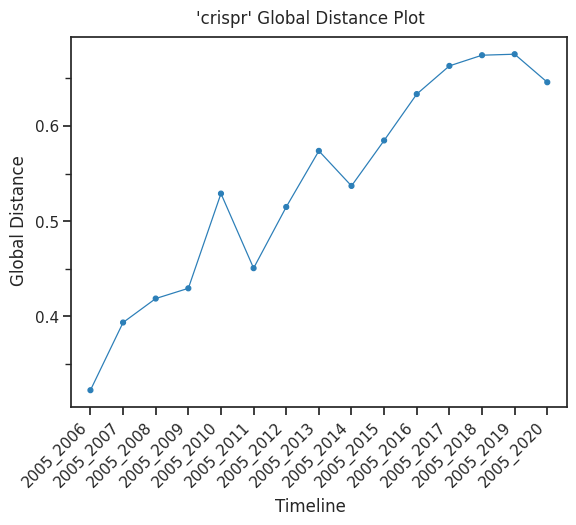

<ggplot: (8785277462704)>

In [11]:
global_distance

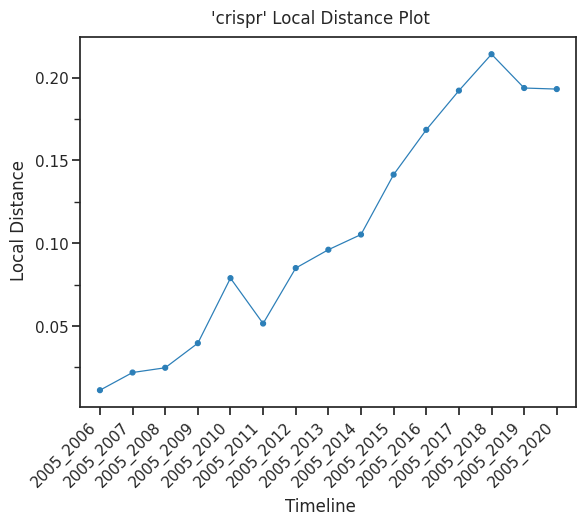

<ggplot: (-9223363251577353777)>

In [12]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/crispr_time_plot.png


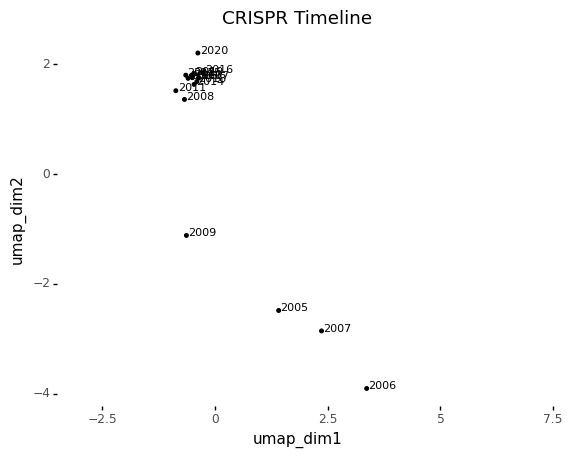

<ggplot: (-9223363251577181934)>


In [13]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/crispr_time_plot.png")
print(g)

In [14]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2005_2020/crispr.gif",
)

![crispr gif here](output/wordcloud_plots_2005_2020/crispr.gif)

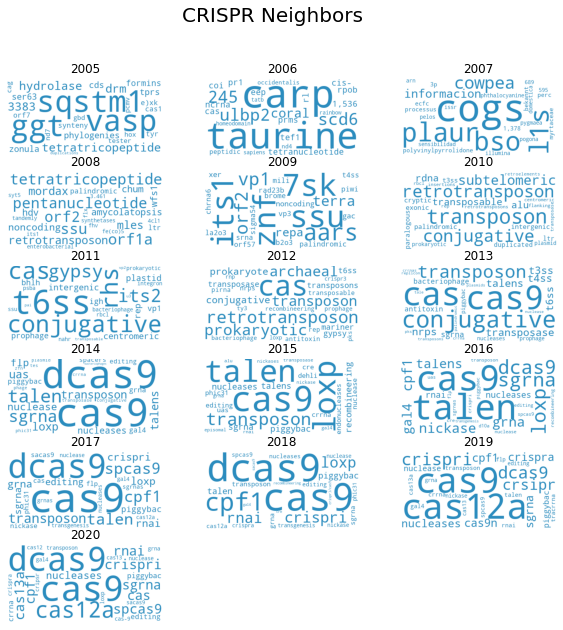

In [15]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2005_2020/crispr.png",
)

# Conclusions - Take Home Point(s)

1. CRISPR has a nice transition from microbiology to genome editing. Word cloud neighbors does wonders in observing this transition.